# Plotting Functions in Azure Machine Learning Package for Forecasting (AMLPF)
In this notebook, we go over the plotting functions in AMLPF for visualizing and analyzing forecasting results. The following functions are covered.
1. Plot aggregated error distribution. 
2. Plot error density function.
3. Plot error histogram.
4. Plot the total forecast vs. actual of the target column.
5. Plot forecast vs. actual by grain.

## Import packages

In [1]:
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")
    
import matplotlib
matplotlib.use('agg')
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import math
import pandas as pd

from ftk import TimeSeriesDataFrame, ForecastDataFrame
from ftk.models import SeasonalNaive
from ftk.data import load_dow_jones_dataset

print('Imports done')

Imports done


## Data Preparation
We first fit a seasonal naive model on the Dow Jones dataset. The forecast results are used to demonstrate the plotting functions in the following sections.

In [2]:
# Load the data
train_tsdf, test_tsdf = load_dow_jones_dataset(test_size=8)

# Set model parameters
frequency = 'QS'
seasonality = 4

# Fit the a seasonal naive model on the training data
snaive_model = SeasonalNaive(freq=frequency, seasonality=seasonality)
snaive_model_fitted = snaive_model.fit(train_tsdf)

# Forecast on test data
forecast = snaive_model_fitted.predict(test_tsdf)
forecast.head(10)

,,,revenue,DistributionForecastSeasonalNaive,PointForecastSeasonalNaive
quarter_start,company_ticker,origin,,,
2013-07-01,AAPL,2013-04-01,37472.00,<scipy.stats._distn_infrastructure.rv_frozen o...,35966.00
2013-10-01,AAPL,2013-04-01,57594.00,<scipy.stats._distn_infrastructure.rv_frozen o...,54512.00
2014-01-01,AAPL,2013-04-01,45646.00,<scipy.stats._distn_infrastructure.rv_frozen o...,43603.00
2014-04-01,AAPL,2013-04-01,37432.00,<scipy.stats._distn_infrastructure.rv_frozen o...,35323.00
2014-07-01,AAPL,2013-04-01,42123.00,<scipy.stats._distn_infrastructure.rv_frozen o...,35966.00
2014-10-01,AAPL,2013-04-01,74599.00,<scipy.stats._distn_infrastructure.rv_frozen o...,54512.00
2015-01-01,AAPL,2013-04-01,58010.00,<scipy.stats._distn_infrastructure.rv_frozen o...,43603.00
2015-04-01,AAPL,2013-04-01,49605.00,<scipy.stats._distn_infrastructure.rv_frozen o...,35323.00
2013-07-01,AXP,2013-04-01,8301.00,<scipy.stats._distn_infrastructure.rv_frozen o...,7862.00


## Plot Aggregated Error Distribution

### Basic usage of `show_error`  
By default, the `show_error` method of `ForecastDataFrame` plots the Mean Absolute Percentage Error(MAPE) distribution by grain. Optionally, you can use the `sorted` argument to sort grains by MAPE in `ascending` or `descending` order.   
The figure and axes objects are returned to the user for further customization.

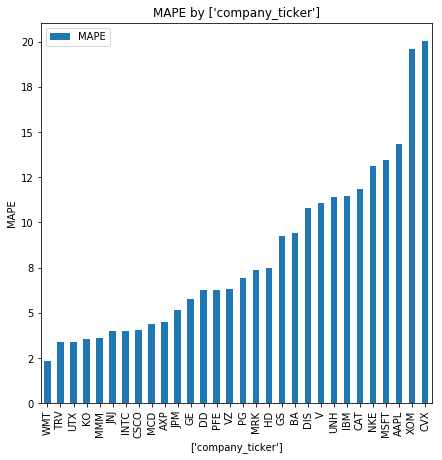

In [3]:
fig1, ax1 = forecast.show_error(sorted='ascending', figure_size=(7,7))

### Plot error by arbitrary column or transformation of a column
Sometimes it's useful to visualize the error distribution by a different column or a transformation of a column. For example, we can visualize error distribution by different revenue ranges, 0 - 10k, 10k - 20k, ...above 130k. 

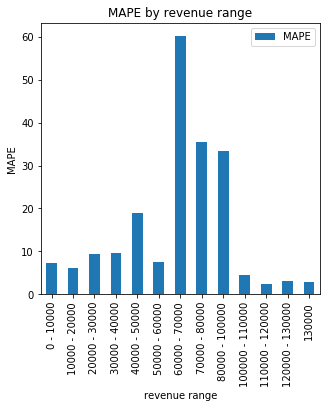

In [5]:
# Define the mapping/transformation
def mapping(x):
    if np.isnan(x):
        return 0
    return math.floor(x/10000) * 10000

# Use the by_col argument to specify an alternative column to grain_colnames.
# Use the col_mapping argument to specify the transformation to apply on by_col
fig2, ax2 = forecast.show_error(by_col='revenue', col_mapping=mapping, figure_size=(5,5))

# Format the x ticks, x a label, and title properly using the returned axes object
labels = [item.get_text() for item in ax2.get_xticklabels()]
for i in range(len(labels) - 1):
    labels[i] = labels[i] + ' - ' + labels[i+1]
ax2.set_xticklabels(labels)
ax2.set(xlabel='revenue range', title='MAPE by revenue range')
plt.show()

### Plot error of grains with top/bottom performance.
Sometimes, you may only be interested in the grains/groups with the best or worst performance, especially when you have a large number of time series. The `performance_percent` argument of `show_error` allows you to specify a performance interval and plot the error of a subset of grains/groups. For example, setting `performance_percent=(0.9, 1)` plots the grains with the top 10% error (i.e. bottom 10% performance). 

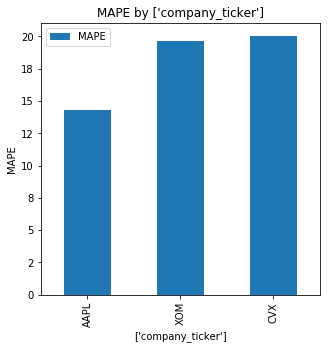

In [7]:
fig3, ax3 = forecast.show_error(performance_percent=(0.9, 1), figure_size=(5,5))

### Custom error functions
In addtion to the default metric, MAPE, you can also plot other built-in metrics like 'MAE', 'RMSE', 'SMAPE',  and 'MASE'. You can even define a custom function to calculate any other performance metrics. For example, here we define a custom function to calculate the Median Absolute Percentage Error (Median APE). 

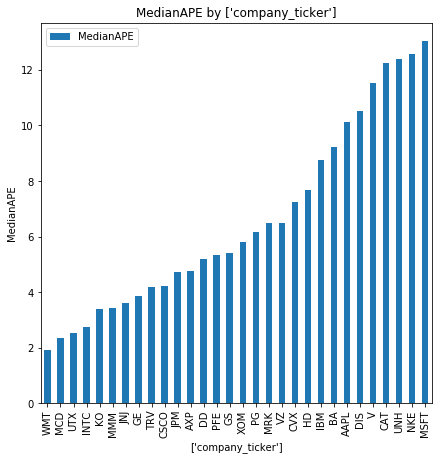

In [8]:
def calc_median_ape(y_true, y_pred):
    y_true = np.array(y_true).astype(float)
    y_pred = np.array(y_pred).astype(float)
    y_true_rm_na = y_true[~(np.isnan(y_true) | np.isnan(y_pred))]
    y_pred_rm_na = y_pred[~(np.isnan(y_true) | np.isnan(y_pred))]
    y_true = y_true_rm_na
    y_pred = y_pred_rm_na
    if len(y_true) == 0:
        # if there is no entries left after removing na data, return np.nan
        return(np.nan)
    y_true_rm_zero = y_true[y_true != 0]
    y_pred_rm_zero = y_pred[y_true != 0]
    if len(y_true_rm_zero) == 0:
        # if all values are zero, np.nan will be returned.
        return(np.nan)
    ape = np.abs((y_true_rm_zero - y_pred_rm_zero) / y_true_rm_zero) * 100
    median_ape = np.median(ape)
    return median_ape


fig4, ax4 = forecast.show_error(err_name='MedianAPE', err_fun=calc_median_ape, sorted='ascending', figure_size=(7,7))

## Plot Error Density Function

The `plot_error_density` method of `ForecastDataFrame` plots the error probability density function estimated by the [Univariate Kernel Density Estimator of statsmodels](http://www.statsmodels.org/dev/generated/statsmodels.nonparametric.kde.KDEUnivariate.html).

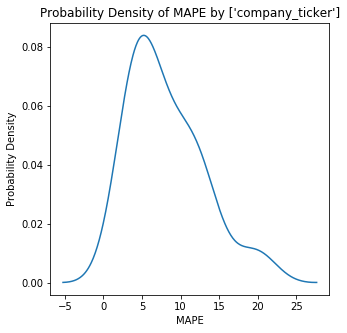

In [18]:
fig5, ax5 = forecast.plot_error_density(figure_size=(5,5))

### Weighted Error Density Function
Optionally, you can weight the error density on a specified column. For example you may want errors of companies with higher revenues to weight more than errors of companies with lower revenues. 

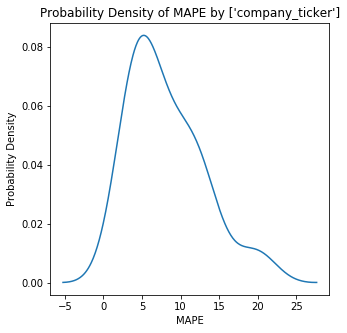

In [19]:
fig6, ax6 = forecast.plot_error_density(weighted_by='revenue', figure_size=(5,5))

## Plot Error Histogram

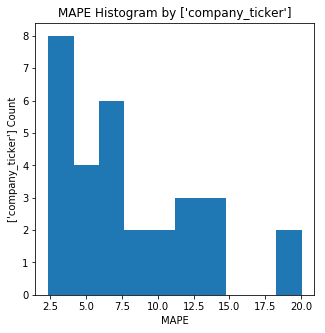

In [17]:
fig7, ax7 = forecast.plot_error_histogram(figure_size=(5,5), grid=False)

## Plot Total Forecast vs. Total Actual
The `plot_forecast_sum` method of `ForecastDataFrame` plots the sum of `pred_point` against the sum of `actual` across all grains for each time point.  
Different from the earlier functions, this method returns a list of (fig, ax) tuples. This is because this function can generate multiple plots when we discuss the `by_horizon` option later. 

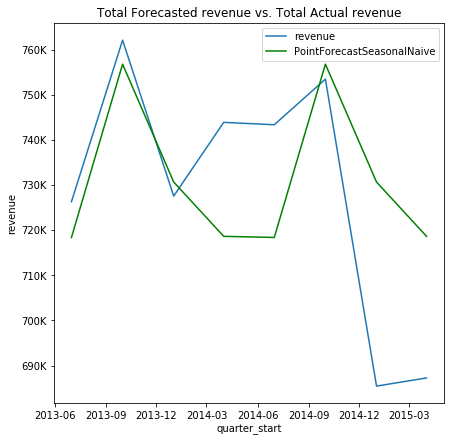

In [16]:
fig_ax_list_1 = forecast.plot_forecast_sum(figure_size=(7, 7))

## Plot Forecast By Grain

Once you have an idea of the overall performance, you may want to explore individual grains, especially those performed poorly. The `plot_forecast_by_grain` method generates a plot for each grain sepecified by the `grains` argument. If the `grains` argument is not set, only the first grain is plotted, which prevents generating a large number of plots when you have many grains.     
Here, we take a look at the two grains with the worst performance discovered by the `show_error` method. 

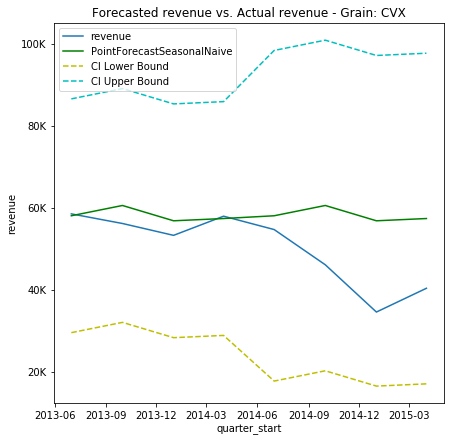

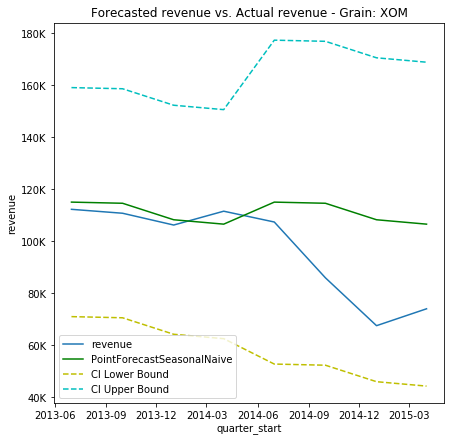

In [20]:
 fig_ax_list_2 = forecast.plot_forecast_by_grain(grains=['CVX', 'XOM'], prediction_interval=True, figure_size=(7, 7))

## Plot Forecast By Horizon
When you have multiple forecasts for the same date generated from different origin time points, i.e. multi-horizon forecasts, plotting all the horizons in the same plot makes the plot hard to interpret. Both `plot_forecast_sum` and `plot_forecast_by_grain` provide an option, `by_horizon`, to generate a separate plot for each horizon. By default, all horizons are plotted. The `horizon` option allows you to specify a subset of horizons to plot.  
To demonstrate this functionality, we handcraft a dataset with two-horizon forecasts for the same date. 

In [15]:
data_origin = {'date': pd.to_datetime(['2017-01-01', '2017-01-02',
                                       '2017-01-02', '2017-01-03',
                                       '2017-01-03', '2017-01-04',
                                       '2017-01-04', '2017-01-05',
                                       '2017-01-01', '2017-01-02',
                                       '2017-01-02', '2017-01-03',
                                       '2017-01-03', '2017-01-04',
                                       '2017-01-04', '2017-01-05']),
               'grain': ['a'] * 8 + ['b'] * 8,
               'origin_time': pd.to_datetime(
                   ['2016-12-31'] * 2 + ['2017-01-01'] * 2 +
                   ['2017-01-02'] * 2 + ['2017-01-03'] * 2 +
                   ['2016-12-31'] * 2 + ['2017-01-01'] * 2 +
                   ['2017-01-02'] * 2 + ['2017-01-03'] * 2),
               'pred_point': [0.779, 2.039, 3.747, 4.106, -0.378,
                              2.826, 1.504, 4.851, 5.775, 6.399,
                              6.014, 7.998, 4.308, 5.801, 7.920,
                              8.015],
               'actual': [1., 2., 2., 3., 3., 4., 4., 5., 6., 7., 7., 8., 8.,
                          9., 9., 10.]
               }
fdf = ForecastDataFrame(data_origin, grain_colnames='grain',
                        time_colname='date', actual='actual',
                        pred_point='pred_point',
                        origin_time_colname='origin_time')
fdf.head()

actual  pred_point
date       grain origin_time                    
2017-01-01 a     2016-12-31     1.00        0.78
2017-01-02 a     2016-12-31     2.00        2.04
                 2017-01-01     2.00        3.75
2017-01-03 a     2017-01-01     3.00        4.11
                 2017-01-02     3.00       -0.38

### Plot total forecast by horizon

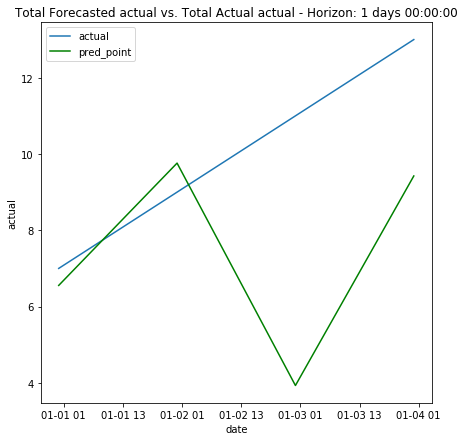

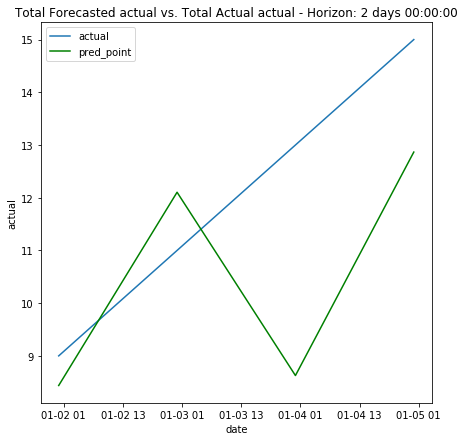

In [21]:
fit_ax_list_3 = fdf.plot_forecast_sum(by_horizon=True, figure_size=(7, 7))

### Plot forecast of each grain by horizon

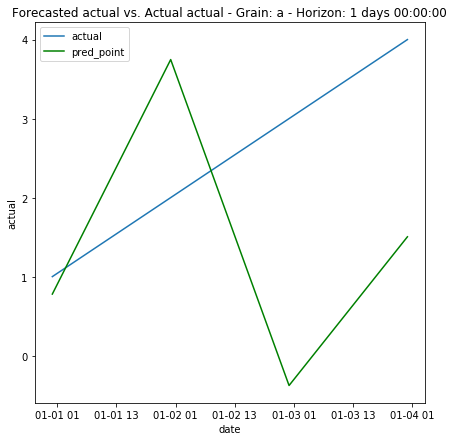

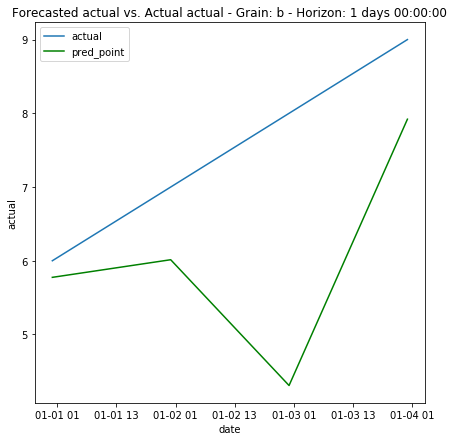

In [22]:
fit_ax_list_4 = fdf.plot_forecast_by_grain(grains=['a', 'b'], 
                                           by_horizon=True, 
                                           figure_size=(7, 7), 
                                           horizon=pd.Timedelta('1 days'))